## Netflix content strategy analysis

## Table of Contents
Importing Necessary Libraries

Loading and Inspecting the Data

Data Preparation

Visualizing Total Viewership Hours by Content Type

Visualizing Total Viewership Hours by Language

Visualizing Total Viewership Hours by Release Month

Identifying Top 5 Titles by Viewership Hours

Visualizing Viewership Trends by Content Type and Release Month

Visualizing Total Viewership Hours by Release Season

Visualizing Monthly Release Patterns and Viewership Hours

Visualizing Weekly Release Patterns and Viewership Hours

Visualizing Releases Near Significant Holidays



In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [18]:
# Load the dataset
try:
    netflix_data = pd.read_csv("netflix.csv")
    print("Initial Data:")
    print(netflix_data.head())
except FileNotFoundError:
    print("Error: The file 'netflix.csv' was not found. Please ensure the file exists in the specified directory.")


Initial Data:
                                 Title Available Globally? Release Date  \
0            The Night Agent: Season 1                 Yes   2023-03-23   
1            Ginny & Georgia: Season 2                 Yes   2023-01-05   
2   The Glory: Season 1 // 더 글로리: 시즌 1                 Yes   2022-12-30   
3                  Wednesday: Season 1                 Yes   2022-11-23   
4  Queen Charlotte: A Bridgerton Story                 Yes   2023-05-04   

   Hours Viewed Language Indicator Content Type  
0  81,21,00,000            English         Show  
1  66,51,00,000            English         Show  
2  62,28,00,000             Korean         Show  
3  50,77,00,000            English         Show  
4  50,30,00,000            English        Movie  


In [19]:
netflix_data.columns = netflix_data.columns.str.strip()
print("\nColumn Names after Stripping Spaces:", netflix_data.columns.tolist())
netflix_data['Hours Viewed'] = netflix_data['Hours Viewed'].replace(',', '', regex=True).astype(float)

print("\nData Types after Conversion:")
print(netflix_data.dtypes)



Column Names after Stripping Spaces: ['Title', 'Available Globally?', 'Release Date', 'Hours Viewed', 'Language Indicator', 'Content Type']

Data Types after Conversion:
Title                   object
Available Globally?     object
Release Date            object
Hours Viewed           float64
Language Indicator      object
Content Type            object
dtype: object


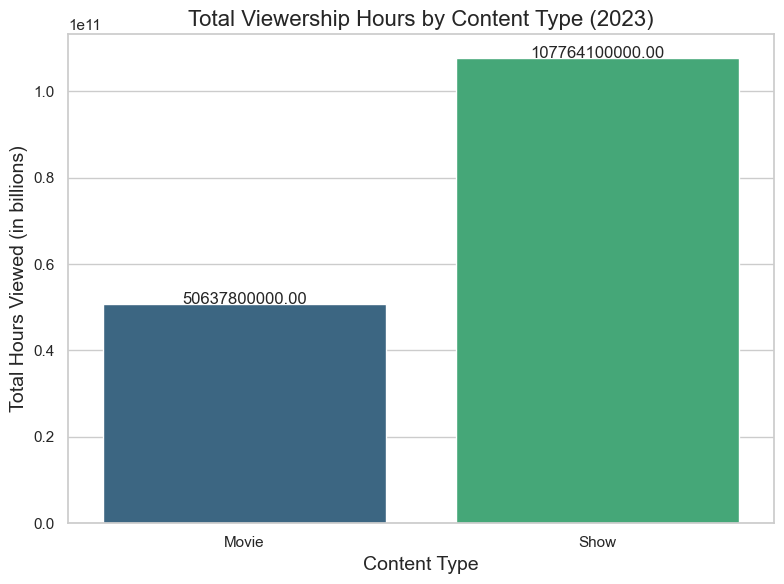

In [20]:
# Aggregate viewership hours by content type
content_type_viewership = netflix_data.groupby('Content Type')['Hours Viewed'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=content_type_viewership, x='Content Type', y='Hours Viewed', palette='viridis')

plt.title('Total Viewership Hours by Content Type (2023)', fontsize=16)
plt.xlabel('Content Type', fontsize=14)
plt.ylabel('Total Hours Viewed (in billions)', fontsize=14)

for index, row in content_type_viewership.iterrows():
    plt.text(index, row['Hours Viewed'] + 0.05, f"{row['Hours Viewed']:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


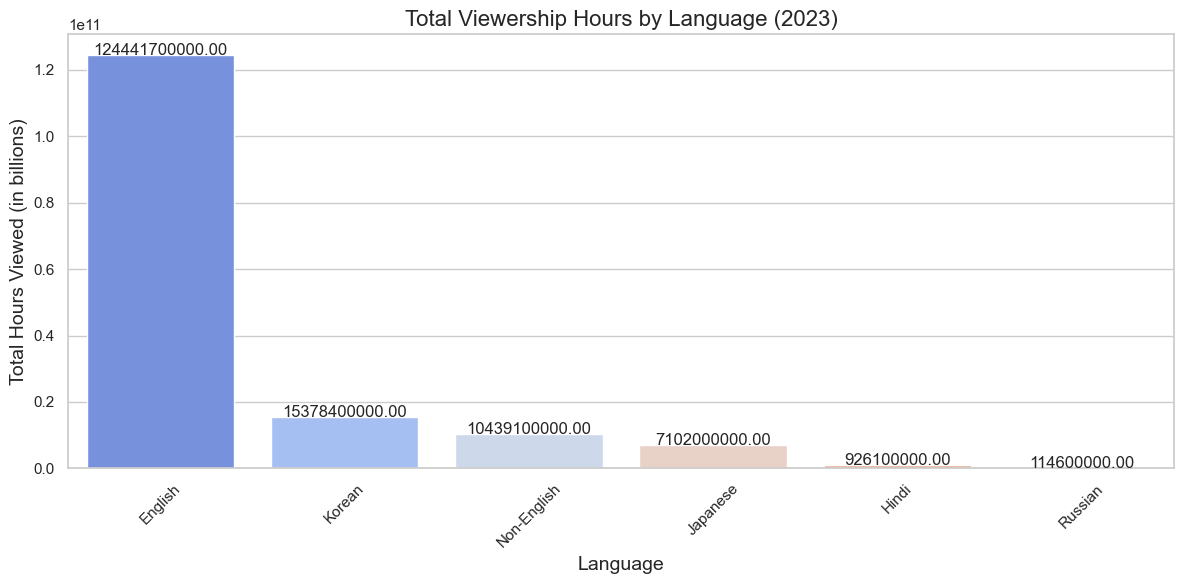

In [21]:
# Aggregate viewership hours by language
language_viewership = netflix_data.groupby('Language Indicator')['Hours Viewed'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=language_viewership, x='Language Indicator', y='Hours Viewed', palette='coolwarm')

plt.title('Total Viewership Hours by Language (2023)', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Total Hours Viewed (in billions)', fontsize=14)
plt.xticks(rotation=45)
for index, row in language_viewership.iterrows():
    plt.text(index, row['Hours Viewed'] + 0.05, f"{row['Hours Viewed']:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


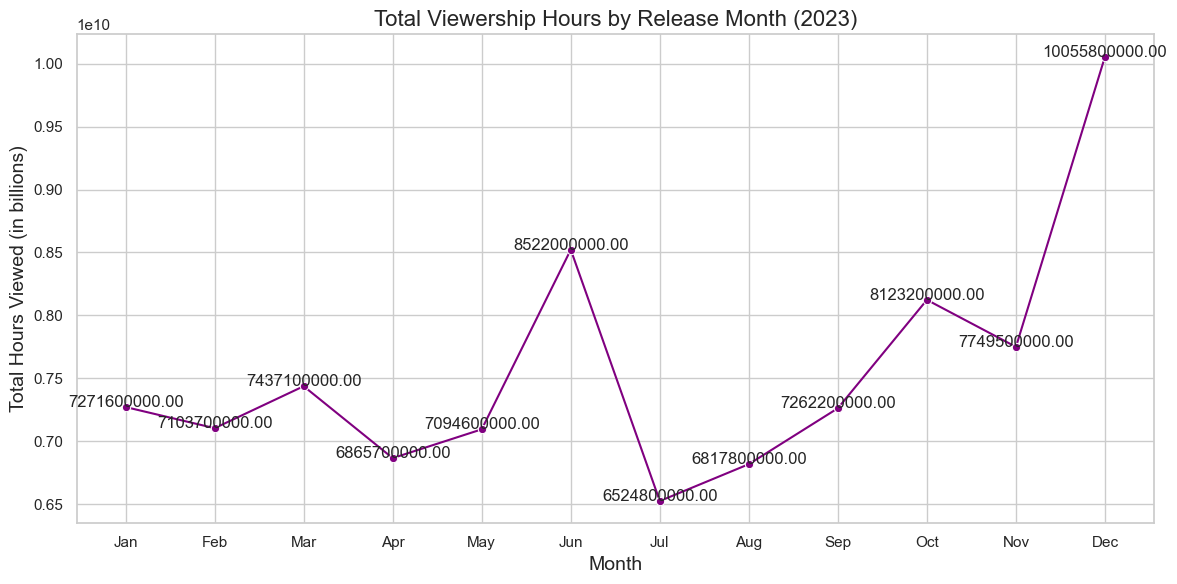

In [22]:
# Convert 'Release Date' to datetime format and extract the month
netflix_data['Release Date'] = pd.to_datetime(netflix_data['Release Date'])
netflix_data['Release Month'] = netflix_data['Release Date'].dt.month

# Aggregate viewership hours by release month
monthly_viewership = netflix_data.groupby('Release Month')['Hours Viewed'].sum().reset_index()
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_viewership['Release Month'] = monthly_viewership['Release Month'].map(month_mapping)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_viewership, x='Release Month', y='Hours Viewed', marker='o', color='purple')
plt.title('Total Viewership Hours by Release Month (2023)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Hours Viewed (in billions)', fontsize=14)

plt.gca().set_xticklabels(month_mapping.values())
for index, row in monthly_viewership.iterrows():
    plt.text(row['Release Month'], row['Hours Viewed'] + 0.05, f"{row['Hours Viewed']:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [23]:
# Extract the top 5 titles based on viewership hours
top_5_titles = netflix_data.nlargest(5, 'Hours Viewed')[['Title', 'Hours Viewed', 'Language Indicator', 'Content Type', 'Release Date']]
print("\nTop 5 Titles by Viewership Hours:")
print(top_5_titles)



Top 5 Titles by Viewership Hours:
                                                 Title  Hours Viewed  \
0                            The Night Agent: Season 1   812100000.0   
1                            Ginny & Georgia: Season 2   665100000.0   
18227  King the Land: Limited Series // 킹더랜드: 리미티드 시리즈   630200000.0   
2                   The Glory: Season 1 // 더 글로리: 시즌 1   622800000.0   
18214                              ONE PIECE: Season 1   541900000.0   

      Language Indicator Content Type Release Date  
0                English         Show   2023-03-23  
1                English         Show   2023-01-05  
18227             Korean        Movie   2023-06-17  
2                 Korean         Show   2022-12-30  
18214            English         Show   2023-08-31  


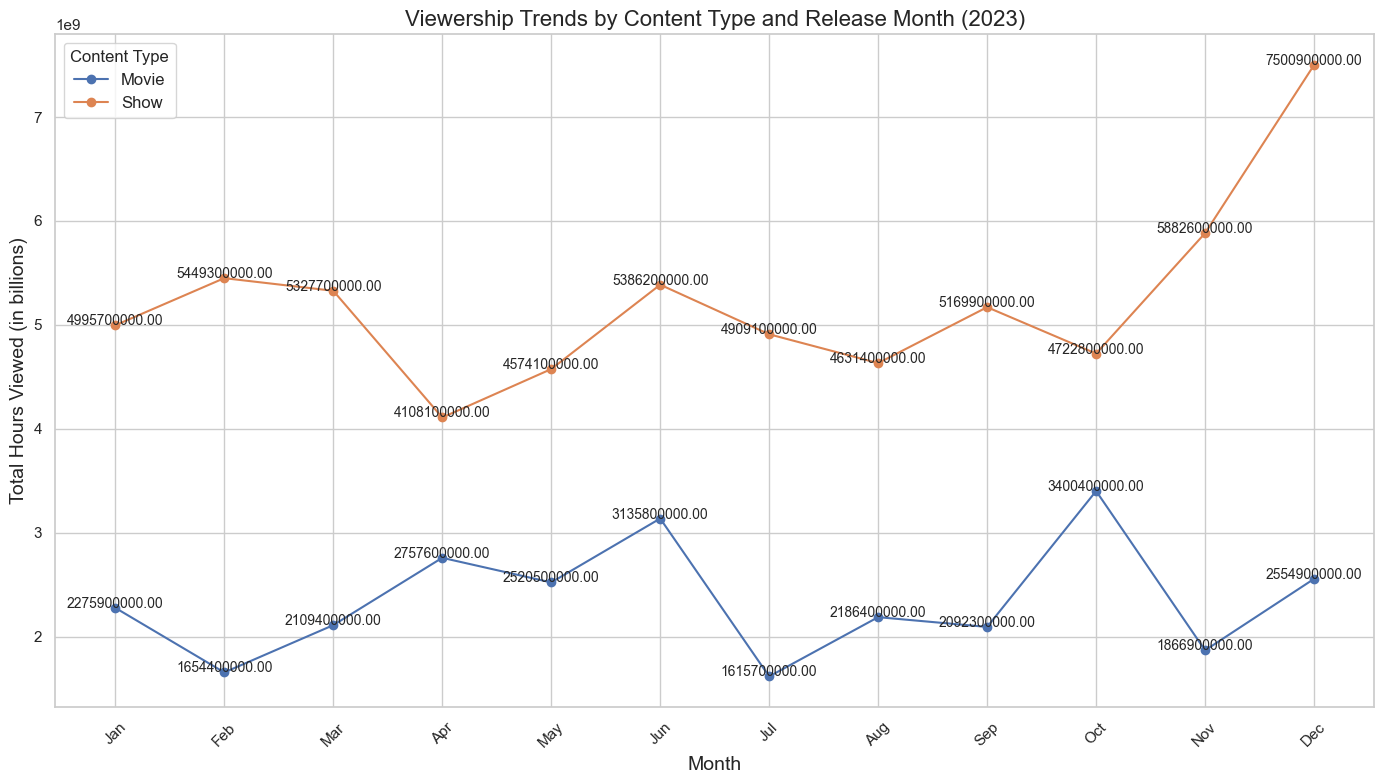

In [24]:
# Aggregate viewership hours by content type and release month
monthly_viewership_by_type = netflix_data.pivot_table(
    index='Release Month',
    columns='Content Type',
    values='Hours Viewed',
    aggfunc='sum'
).reset_index()

monthly_viewership_by_type['Release Month'] = monthly_viewership_by_type['Release Month'].map(month_mapping)

plt.figure(figsize=(14, 8))

for content_type in monthly_viewership_by_type.columns[1:]:
    plt.plot(
        monthly_viewership_by_type['Release Month'],
        monthly_viewership_by_type[content_type],
        marker='o',
        label=content_type
    )

plt.title('Viewership Trends by Content Type and Release Month (2023)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Hours Viewed (in billions)', fontsize=14)
plt.legend(title='Content Type', fontsize=12)
plt.xticks(rotation=45)

for content_type in monthly_viewership_by_type.columns[1:]:
    for x, y in zip(monthly_viewership_by_type['Release Month'], monthly_viewership_by_type[content_type]):
        plt.text(x, y + 0.05, f"{y:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


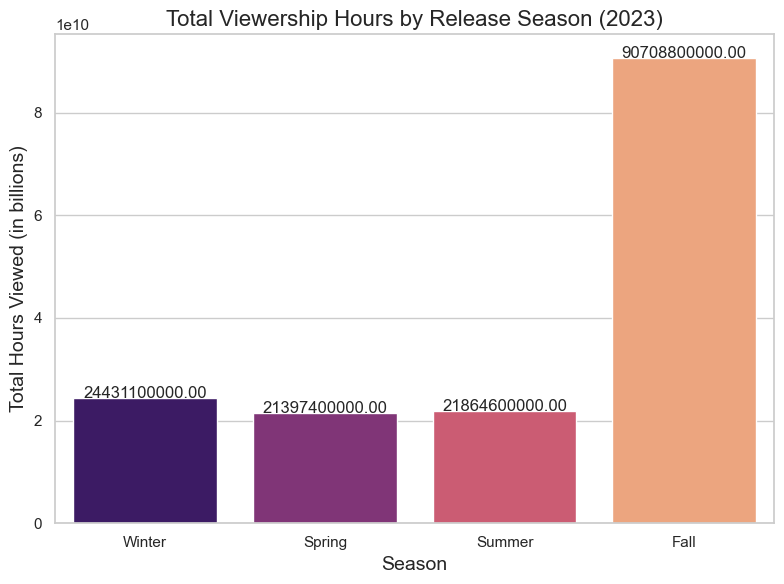

In [25]:
# Define seasons based on release months
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
netflix_data['Release Season'] = netflix_data['Release Month'].apply(get_season)
seasonal_viewership = netflix_data.groupby('Release Season')['Hours Viewed'].sum().reindex(['Winter', 'Spring', 'Summer', 'Fall']).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=seasonal_viewership, x='Release Season', y='Hours Viewed', palette='magma')
plt.title('Total Viewership Hours by Release Season (2023)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Total Hours Viewed (in billions)', fontsize=14)

for index, row in seasonal_viewership.iterrows():
    plt.text(index, row['Hours Viewed'] + 0.05, f"{row['Hours Viewed']:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [31]:
monthly_releases = netflix_data['Release Month'].value_counts().sort_index()

monthly_viewership = netflix_data.groupby('Release Month')['Hours Viewed'].sum()

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=monthly_releases.index,
        y=monthly_releases.values,
        name='Number of Releases',
        marker_color='goldenrod', 
        opacity=0.7,
        yaxis='y1'
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_viewership.index,
        y=monthly_viewership.values,
        name='Viewership Hours',
        mode='lines+markers',
        marker=dict(color='red'),
        line=dict(color='red'),
        yaxis='y2'
    )
)

fig.update_layout(
    title='Monthly Release Patterns and Viewership Hours (2023)',
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    yaxis=dict(
        title='Number of Releases',
        showgrid=False,
        side='left'
    ),
    yaxis2=dict(
        title='Total Hours Viewed (in billions)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    legend=dict(
        x=1.05,  
        y=1,
        orientation='v',
        xanchor='left'
    ),
    height=600,
    width=1000
)

fig.show()

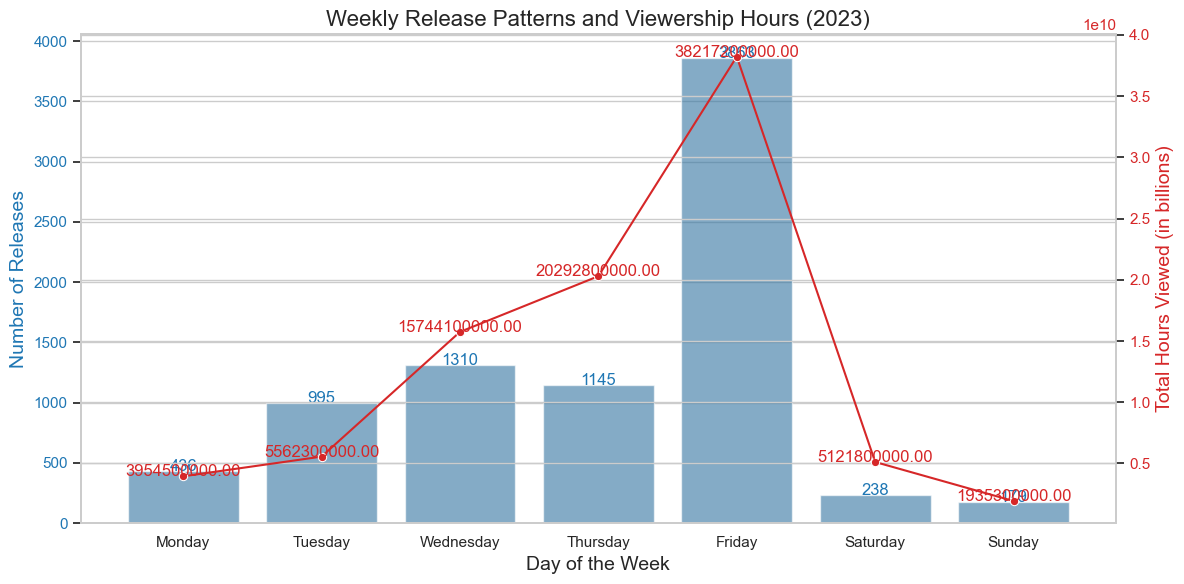

In [28]:
# Extract the day name from the 'Release Date'
netflix_data['Release Day'] = netflix_data['Release Date'].dt.day_name()

weekday_releases = netflix_data['Release Day'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()
weekday_releases.columns = ['Release Day', 'Number of Releases']
weekday_viewership = netflix_data.groupby('Release Day')['Hours Viewed'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()
weekday_viewership.columns = ['Release Day', 'Hours Viewed']

weekly_data = pd.merge(weekday_releases, weekday_viewership, on='Release Day')

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Day of the Week', fontsize=14)
ax1.set_ylabel('Number of Releases', color=color, fontsize=14)
sns.barplot(x='Release Day', y='Number of Releases', data=weekly_data, color=color, alpha=0.6, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
for index, row in weekly_data.iterrows():
    ax1.text(index, row['Number of Releases'] + 0.05, f"{row['Number of Releases']}", ha='center', fontsize=12, color=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Total Hours Viewed (in billions)', color=color, fontsize=14)
sns.lineplot(x='Release Day', y='Hours Viewed', data=weekly_data, color=color, marker='o', ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

for index, row in weekly_data.iterrows():
    ax2.text(index, row['Hours Viewed'] + 0.05, f"{row['Hours Viewed']:.2f}", ha='center', fontsize=12, color=color)
plt.title('Weekly Release Patterns and Viewership Hours (2023)', fontsize=16)

fig.tight_layout()
plt.show()


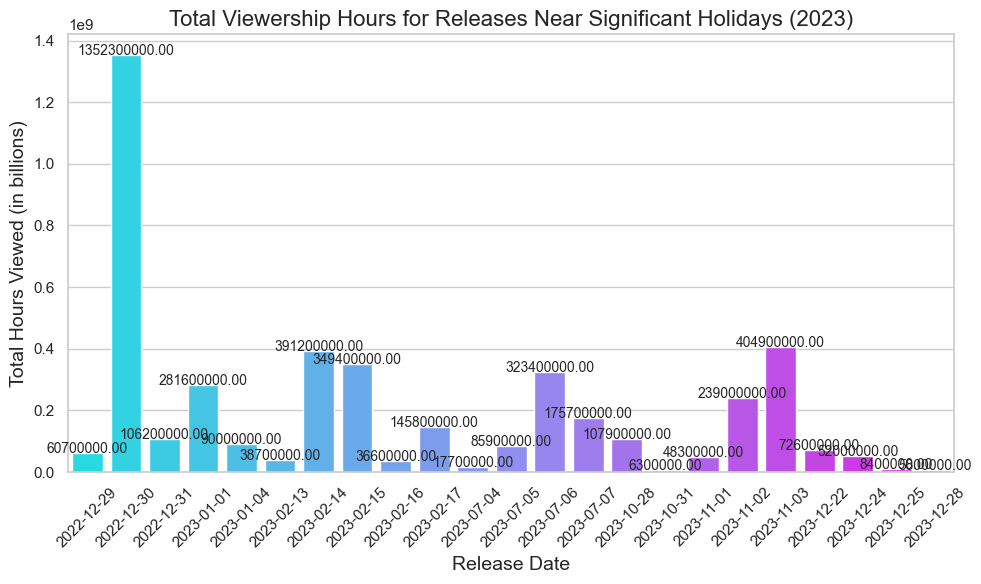

In [30]:
# Define significant holidays and events in 2023
important_dates = [
    '2023-01-01',  # New Year's Day
    '2023-02-14',  # Valentine's Day
    '2023-07-04',  # Independence Day (US)
    '2023-10-31',  # Halloween
    '2023-12-25'   # Christmas Day
]

important_dates = pd.to_datetime(important_dates)

window = 3
def is_near_holiday(date):
    for holiday in important_dates:
        if abs((date - holiday).days) <= window:
            return True
    return False
holiday_releases = netflix_data[netflix_data['Release Date'].apply(is_near_holiday)]

holiday_viewership = holiday_releases.groupby('Release Date')['Hours Viewed'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=holiday_viewership, x='Release Date', y='Hours Viewed', palette='cool')
plt.title('Total Viewership Hours for Releases Near Significant Holidays (2023)', fontsize=16)
plt.xlabel('Release Date', fontsize=14)
plt.ylabel('Total Hours Viewed (in billions)', fontsize=14)
plt.xticks(rotation=45)
for index, row in holiday_viewership.iterrows():
    plt.text(index, row['Hours Viewed'] + 0.05, f"{row['Hours Viewed']:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
